In [73]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import fmin_l_bfgs_b
from sklearn.datasets.samples_generator import make_blobs
from scipy.linalg import cholesky, cho_solve, solve_triangular

### Create fake dataset

In [74]:
# create fake dataset
X_data, y_data = make_blobs(n_samples=50, centers=2, n_features=3, random_state=10) # 26
y_data[y_data==0] = -1

y_data = y_data.reshape(-1,1)

In [75]:
y.shape

(25, 1)

In [76]:
np.unique(y)

array([-1,  1])

In [77]:
# number of dimension
D = X_data.shape[1]

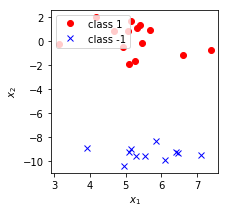

In [78]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(X[y.flatten()==1][:, 0], X[y.flatten()==1][:,1], 'ro', label='class 1')
ax.plot(X[y.flatten()==-1][:, 0], X[y.flatten()==-1][:,1], 'bx', label = 'class -1')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_xlim(-10, 10)
#ax.set_ylim(-5, 15)
ax.legend(loc='upper left')
plt.show()

In [79]:
X = X_data[:25,:]
y = y_data[:25]

#### Kernels

We squared exponential kerne (a.k.a RBF) with hyperparameter $l$:
$$ K(x_i, x_j) = \exp \Big(\frac{-|| x_i - x_j ||^2}{2l^2} \Big) $$

In [80]:
def exp_kernel(a, b, theta_):
    # theta includes number of parameters
    squared_dist = np.linalg.norm(a-b)**2
    return np.exp(-squared_dist/(2*theta_[0]**2))

Automatic Relevance Determination (ARD) squared exponential kernel:
$$ K(x_i, x_j) = \exp \Big( \sum_{i=1}^{D} \frac{-|| x_i - x_j ||^2}{2l_i^2} \Big)  = \exp \Big( \sum_{i=1}^{D} \theta_i^2 \frac{ (-|| x_i - x_j ||^2) }{2} \Big)  $$
where $l_i$ is scaling hyperparameter for each dimension

In [81]:
def ard_exp_kernel(a, b, theta_):
    # theta includes number of parameters
    squared_dist = (a-b)**2
    squared_dist = np.dot(squared_dist, theta_**2)
    #print(squared_dist)
    #print(squared_dist.shape)
    return np.exp(-squared_dist/2)

Recursive ARD kernel:
$$ K(x_i, x_j) = \exp \Big( \sum_{i=1}^{D} \theta_i^2 \frac{ (-|| x_i - x_j ||^2) }{2} \Big) \exp \Big( \frac{K_{pre}(x_i, x_j) - 1}{\rho^2}  \Big)  $$
where $\rho$ is reservoir state parameter

In [82]:
#rho = 1
theta_prev = np.ones(D) # need to assign previous estimate
def recursive_kernel(a, b, theta_):
    # theta includes number of parameters
    current_theta_estimate = theta_[:-1]
    rho = theta_[-1]
    return  ard_exp_kernel(a, b, current_theta_estimate) * np.exp( ( ard_exp_kernel(a, b, theta_prev) - 1 )/rho**2 )

In [83]:
#%%time
K = pairwise_kernels(X, metric=exp_kernel,  theta_=theta_prev)

In [84]:
kernel_type = 'exp_kernel' # 'ard_kernel' 'recursive_kernel' 'ard_exp_kernel'

#### Optimization

We need find paramaters of kernel, in our case it's $l$ to maximize log marginal likelihood.

$$ \mathcal{L} = \log p(\mathbf{y}|X) = -\frac{1}{2} \mathbf{y}^T \mathbf{\alpha} - \sum_{i}^{N}L_{ii} - \frac{N}{2} \log(2 \pi) $$

In [85]:
y.shape

(25, 1)

In [86]:
sigma_n_square = 1e-10

In [87]:
# choose boundaries for optimazation
LOCAL_BOUND = (1e-2, 1e2)
bounds = []
if kernel_type == 'exp_kernel':
    bounds.append(LOCAL_BOUND)
    x0 = np.ones(1) # only one value is optimized
    kernel_func = exp_kernel
else:
    x0 = np.ones(X.shape[1])*10 # all dimension
    kernel_func = ard_exp_kernel
    for i in range(X.shape[1]):
        bounds.append(LOCAL_BOUND)
    if kernel_type == 'recursive_kernel':
        bounds.append(LOCAL_BOUND)
        x0 = np.ones(X.shape[1] + 1)*10 # rho added
        kernel_func = recursive_kernel

In [96]:
def log_marginal_likelihood(theta_, *args):
    #print(kernel_func)
    
    K = pairwise_kernels(X, metric=kernel_func,  theta_=theta_)

    # do Cholesky decomposition
    L = cholesky(K + sigma_n_square*np.eye(len(X)), lower=True)
    #print(L)
    # solve for alpha
    alpha = cho_solve(  (L, True), y )
   # alpha = np.linalg.solve( L.T, np.linalg.solve(L, y) )
    return -( -0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi) )

In [117]:
def optimize_kernel_parameters(x0):
    #x0 = np.array([1])
    
    #bounds =  ((1e-2, 1e2),(1e-2, 1e2),)
    theta_estimate, min_log_marginal_likelihood, info = fmin_l_bfgs_b(func=log_marginal_likelihood, x0 = x0, args=(), bounds=bounds)
    print('Optimization succeded with log marginal likelihood ', min_log_marginal_likelihood[0][0], ' in ', info['funcalls'],' iterations.')
    return  theta_estimate, min_log_marginal_likelihood, info

In [118]:
OPTIMIZATION_ITERATIONS = 10

In [119]:
%%time
log_likelihood_list = []
theta_est_list  = []
for i in range(OPTIMIZATION_ITERATIONS):
    bounds = np.array(bounds)
    theta_initial = np.random.uniform(bounds[:, 0], bounds[:, 1])
    theta_estimate, min_log_marginal_likelihood, info = optimize_kernel_parameters(x0)
    log_likelihood_list.append(min_log_marginal_likelihood[0][0])
    theta_est_list.append(theta_estimate)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [108]:
theta_estimate[np.argmin(log_likelihood_list)]

5.9202415604433964

In [20]:
%%time
theta_estimate, _, info = optimize_kernel_parameters()

<function exp_kernel at 0x7fdf334317b8>
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.22495627e-33  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.57068418e-01  3.67205143e-30  9.87587724e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+0

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.15075320e-01  9.93356769e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.48556910e-01  3.56854856e-02  3.14589151e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [21]:
info

{'grad': array([-0.0126974]),
 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 36,
 'nit': 6,
 'warnflag': 0}

In [22]:
theta_estimate

array([5.92024156])

In [208]:
# make prediction
def predict(x_star, theta):

    # create covariance matrix using kernel
    K = pairwise_kernels(X, metric=kernel_func,  theta_=theta)

    # do Cholesky decomposition
    L = cholesky(K + sigma_n_square*np.eye(X.shape[0]), lower=True)

    # solve for alpha
    alpha = cho_solve(    (L, True),    y   )
    
    L_inv = solve_triangular(L.T, np.eye(L.shape[0]))
    K_inv = L_inv.dot(L_inv.T)

    k_star = pairwise_kernels(x_star, X, metric=kernel_func,  theta_=theta)
    y_mean = k_star.dot(alpha) + np.mean(y)
    y_var = np.ones(x_star.shape[0]) - np.einsum("ij,ij->i", np.dot(k_star, K_inv), k_star)
    y_var[y_var < 0] = 0

    # log marginal likelihood
    log_marg_likelihood = -0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi)
    
    #print(-0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi))
    return y_mean, np.sqrt(y_var), log_marg_likelihood

In [ ]:
elif return_std:
                # cache result of K_inv computation
                if self._K_inv is None:
                    # compute inverse K_inv of K based on its Cholesky
                    # decomposition L and its inverse L_inv
                    L_inv = solve_triangular(self.L_.T,
                                             np.eye(self.L_.shape[0]))
                    self._K_inv = L_inv.dot(L_inv.T)

                # Compute variance of predictive distribution
                y_var = self.kernel_.diag(X)
                y_var -= np.einsum("ij,ij->i",
                                   np.dot(K_trans, self._K_inv), K_trans)

                # Check if any of the variances is negative because of
                # numerical issues. If yes: set the variance to 0.
                y_var_negative = y_var < 0
                if np.any(y_var_negative):
                    warnings.warn("Predicted variances smaller than 0. "
                                  "Setting those variances to 0.")
                    y_var[y_var_negative] = 0.0
                return y_mean, np.sqrt(y_var)

In [209]:
y_pred, y_sigma, y_log_lh = predict(X_data[26:40,:], theta_estimate)

In [258]:
y_sigma, sigma2

(array([8.90809335e-03, 5.34381814e-04, 6.12782561e-04, 1.00000000e-02,
        1.00000000e-02, 3.46852257e-04, 4.35201223e-03, 1.48780061e-03,
        8.94856920e-05, 5.72143979e-04, 1.67277154e-04, 1.00000000e-02,
        2.67517611e-04, 3.02320190e-04]),
 array([0.01853229, 0.00897743, 0.01265912, 0.00280426, 0.00100791,
        0.00155316, 0.04040226, 0.01922495, 0.00083358, 0.00647442,
        0.00165506, 0.00698296, 0.00315689, 0.01542667]))

In [210]:
y_log_lh

array([[80.54867324]])

In [211]:
y_pred

array([[ 1.07262767],
       [ 1.1192514 ],
       [-0.88074777],
       [ 1.11986512],
       [ 1.12009676],
       [ 1.11972654],
       [-0.87483626],
       [ 1.12119285],
       [-0.88010403],
       [-0.88141863],
       [ 1.11997114],
       [ 1.11988416],
       [-0.88069776],
       [-0.87946803]])

In [212]:
y_sigma

array([8.90809335e-03, 5.34381814e-04, 6.12782561e-04, 0.00000000e+00,
       0.00000000e+00, 3.46852257e-04, 4.35201223e-03, 1.48780061e-03,
       8.94856920e-05, 5.72143979e-04, 1.67277154e-04, 0.00000000e+00,
       2.67517611e-04, 3.02320190e-04])

In [213]:
y_data[26:28]

array([[1],
       [1]])

In [214]:
1/np.sqrt(2*np.pi*y_sigma[0]**2)*np.exp( - (y_pred[0] - 1)**2 / (2*y_sigma[0]**2) )

array([1.64834808e-13])

Gaussian distribution
$$ p(x | \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2} } \exp \Big( - \frac{(x-\mu)^2}{2\sigma^2} \Big) $$

In [215]:
y_data[26:40].faltten()

array([[ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1]])

In [243]:
def gaussian_pdf(x_, mu_, sigma_):
    # sigma_[sigma_ == 0] = 1e-2
    #print(y_pred.shape, mu_.shape)
    #print(- (x_ - mu_)**2)
    return  np.exp( - (x_ - mu_)**2 / (2 * sigma_**2) )* 1/ ( np.sqrt(2*np.pi) * sigma_)
#    # return 1/ ( np.sqrt(2*np.pi) * sigma_) * np.exp( - (x_ - mu_)**2 / (2 * sigma_**2) )

In [222]:
y_data[26:40].flatten()

array([ 1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1, -1])

In [220]:
gaussian_pdf(y_pred.flatten(), y_data[26:40].flatten(), y_sigma)

array([1.64834808e-013, 0.00000000e+000, 0.00000000e+000, 2.52323943e-030,
       1.91100060e-030, 0.00000000e+000, 2.24885762e-178, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.46630641e-030,
       0.00000000e+000, 0.00000000e+000])

In [120]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [121]:
# Instantiate a Gaussian Process model
kernel = RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=sigma_n_square)

In [122]:
%%time
# train GP model
gp.fit(X, y.flatten())

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 45.6 ms


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [123]:
1/1.78*2

1.1235955056179776

In [128]:
gp.kernel_

RBF(length_scale=5.92)

In [125]:
gp.log_marginal_likelihood_value_

43.62350588749317

In [113]:
y_pred2, sigma2 = gp.predict(X=X_data[26:40,:], return_std=True)

In [234]:
y_pred2

array([ 0.99437901,  1.00007343, -0.97900384,  1.00142673,  0.99997682,
        0.99648062, -0.92118424,  1.00045283, -0.9980503 , -0.9810328 ,
        1.00106041,  0.99390828, -1.00708078, -1.03470663])

In [235]:
sigma2

array([0.01853229, 0.00897743, 0.01265912, 0.00280426, 0.00100791,
       0.00155316, 0.04040226, 0.01922495, 0.00083358, 0.00647442,
       0.00165506, 0.00698296, 0.00315689, 0.01542667])

In [254]:
gaussian_pdf(x_ = y_pred2[2], mu_= -1, sigma_=sigma2[2] )

7.964514099389359

In [237]:
gaussian_pdf(x_= y_pred2 , mu_= y_data[26:40].flatten(), sigma_=sigma2)

array([ 20.55911528,  44.43689442,   7.9645141 , 124.99228951,
       395.70854939,  19.71245054,   1.47280321,  20.74551847,
        31.04641921,   0.84349169, 196.31637426,  39.04946751,
        10.21438325,   2.05846803])

In [117]:
gp.kernel_

RBF(length_scale=4.5)

In [118]:
y_pred2, y_pred

(array([-0.99999982,  1.        ]), array([[-0.9999996 ],
        [ 1.00000464]]))

In [119]:
sigma2, y_sigma

(array([0.00000000e+00, 2.97069159e-05]), array([0., 0.]))